## Example 1a - SENTINEL Hub Data Access using xcube

This notebook shows the various ways to open data cubes from Sentinel Hub (SH) for a given time range, region, and spatial resolution:

1. A **temporarily regular Sentinel-2 cube** with aggregated observations that fall into equal-size time periods;
2. A **temporarily irregular Sentinel-2 cube** which only includes time stamps where there were valid observations and saving the cube to an S3 bucket;
3. A cube using **projected coordinates**.
4. Writing to and reopen from (S3) **object storage**.


To run this Notebook, make sure the SENTINEL Hub / xcube Integration is setup correctly, see [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [1]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.observers import Observers
from xcube_sh.viewer import ViewerServer

# xcube imports
import xcube
from xcube.core.dsio import write_cube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry


# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import time
import zarr

In [2]:
%matplotlib inline

---
For this demo, we are focussing on small coastal area near Kiel in Northern Germany (Baltic Sea)

In [3]:
x1 = 10.00  # degree
y1 = 54.27  # degree
x2 = 11.00  # degree
y2 = 54.60  # degree

bbox = x1, y1, x2, y2

Visualize the bounding box. If you don't see anything, please refer to [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [4]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

Later in this NB we are going to compute some indexes from bands atmospherically corrected bands B04, B05, B06, B11 of Sentinel-2 (S2L2A)
Our time range covers two and a half month of last year's summer: 2018-05-14 to 2018-07-31

The desired resolution is roughly 20 meters per pixel:

In [5]:
spatial_res = 0.00018   # = 20.038 meters in degree>

---
### Example 1a1 - Fetch Observations in given Region aggregated into 2-Day Intervals

Sentinel-2 L2A with aggregated observations that fall into equal-size `time_period` of 2 days:

In [6]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],
                         time_period='2D')

We define a `request_collector` as an observer for SH requests made, so we can show SH usage stats. This is a developer tool, useful for demonstration purposes too. **Otherwise, this is not needed.**

In [7]:
request_collector = Observers.request_collector()

Open a data cube:

In [8]:
cube = open_cube(cube_config, observer=request_collector)

In [9]:
cube

<xarray.Dataset>
Dimensions:    (time: 40, lat: 2048, lon: 5632, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time       (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(40, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-03-13T14:15:32.838242
    time_coverage_start:       2018-05-14T00:00:00+00:00
    time_coverage_end:         2018-08-02T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P2DT0H0M0S
    geospatial_lon_min:        10.0
    geospatial_lat_min:        54.27
    geospatial_lon_max:        11.01376
    geospatial_lat_max:        54.63864
    processing_level:          L2A

No requests have been made yet. Requests are made only if data is actually required.

In [10]:
request_collector.stats

Note, the cube's time coordinates are monotonically increasing and the distance between two time steps is varying:

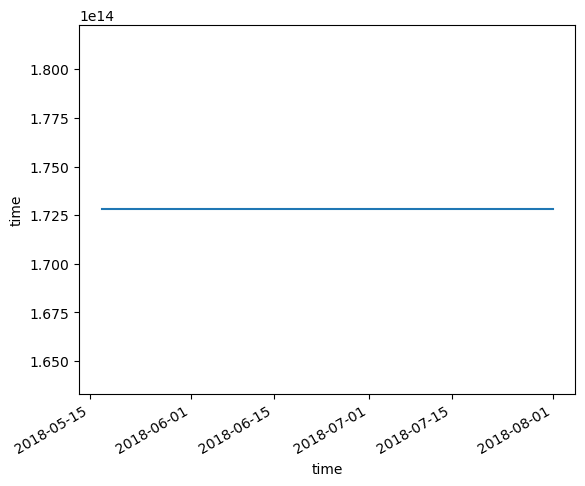

In [11]:
cube.time.diff(dim='time').plot.line()

In [12]:
cube.B04

<xarray.DataArray 'B04' (time: 40, lat: 2048, lon: 5632)>
dask.array<open_dataset-B04, shape=(40, 2048, 5632), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon      (lon) float64 10.0 10.0 10.0 10.0 10.0 ... 11.01 11.01 11.01 11.01
  * time     (time) datetime64[ns] 2018-05-15 2018-05-17 ... 2018-08-01
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    664.75
    wavelength_a:  664.6
    wavelength_b:  664.9
    bandwidth:     31.0
    bandwidth_a:   31
    bandwidth_b:   31
    resolution:    10

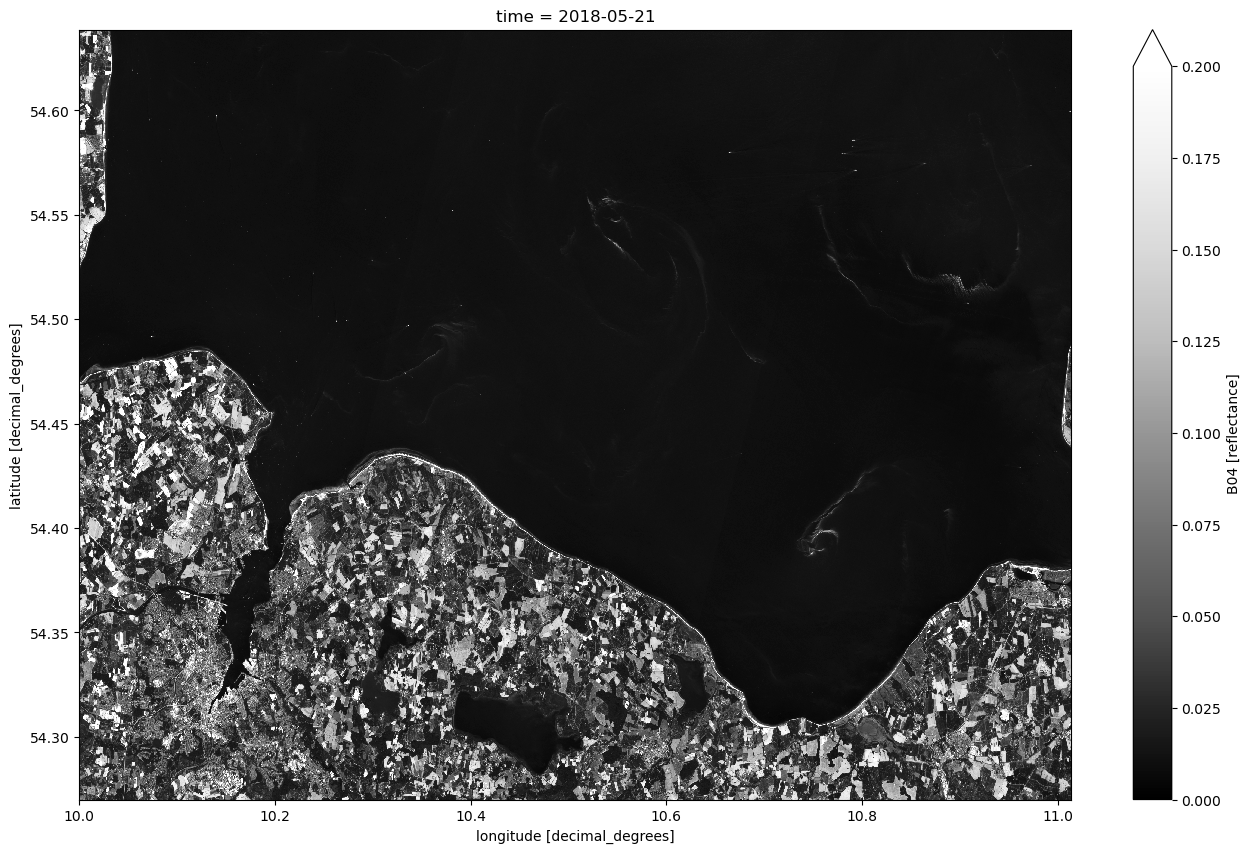

In [13]:
cube.B04.sel(time='2018-05-21 10:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(16, 10))

Now SentinelHub data requests have been made

In [14]:
request_collector.stats

Number of requests:,44
Request duration min:,396.09 ms
Request duration max:,1685.62 ms
Request duration median:,585.90 ms
Request duration mean:,764.37 ms
Request duration std:,379.71 ms


xcube mask sets also follow data cube structure

---
### Example 1a2 - Fetch all Observations in given Region

Sentinel-2 L2A which only includes time stamps where there were valid observations for a given region. We use a `time_tolerance` of 30 minutes to decide whether scenes shall be combined:

In [15]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
                         tile_size=[1024, 1024],
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-14', '2018-07-31'],                         
                         time_tolerance='30M')

d:\projects\xcube-sh\xcube_sh\config.py:239: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


In [16]:
cube = open_cube(cube_config, observer=request_collector)
cube

<xarray.Dataset>
Dimensions:    (time: 45, lat: 2048, lon: 6144, bnds: 2)
Coordinates:
  * lat        (lat) float64 54.64 54.64 54.64 54.64 ... 54.27 54.27 54.27 54.27
  * lon        (lon) float64 10.0 10.0 10.0 10.0 ... 11.11 11.11 11.11 11.11
  * time       (time) datetime64[ns] 2018-05-15T10:30:24 ... 2018-07-29T10:30:19
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(45, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2024-03-13T14:15:37.427869
    time_coverage_start:     2018-05-15T10:30:24+00:00
    time_coverage_end:       2018-07-29T10:30:19+00:00
    time_coverage_duration:  P74DT23H59M55S
    geospatial_lon_min:      10.0
    geospatial_lat_min:      54.27
    geospatial_lon_max:      11.10592
    geospatial_lat_max:      54.63864
    processing_level:        L2A

In [17]:
request_collector.stats

Number of requests:,44
Request duration min:,396.09 ms
Request duration max:,1685.62 ms
Request duration median:,585.90 ms
Request duration mean:,764.37 ms
Request duration std:,379.71 ms


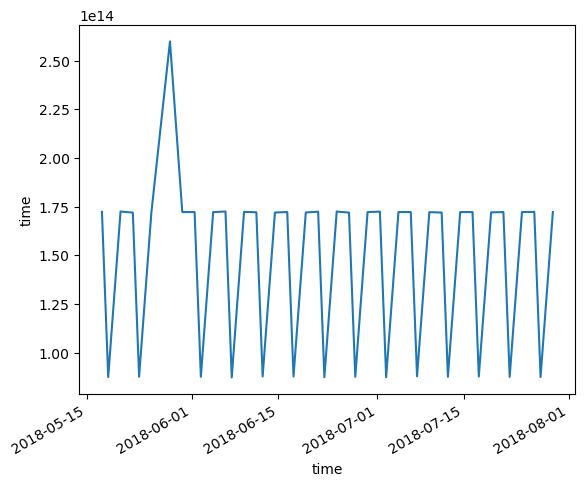

In [18]:
cube.time.diff(dim='time').plot.line()

---
### Example 1a3 - Fetching a Data Cube using another Projection

We now want to fetch a data cube in a given map projection _Pseudo-Mercator_ (EPSG:3857) instead of the Lat/Lon rectangular default projection. This requires setting the `crs` parameter to `'http://www.opengis.net/def/crs/EPSG/0/3857'`. Note that in the output, the spatial coordinate names switched from `lon`, `lat` to `x`, `y`. For other projections, refer to https://docs.sentinel-hub.com/api/latest/#/API/crs.

We need to provide the `bbox` and `spatial_res` parameters in EPSG:3857 units (meters) now, Ljubljana area: 

In [19]:
x1 = 1545577  # meters
y1 = 5761986  # meters
x2 = 1705367  # meters
y2 = 5857046  # meters

bbox = x1, y1, x2, y2

spatial_res = (x2 - x1) / 512  # meters

Verify we are right:

In [20]:
geom = shapely.geometry.box(*bbox)

import functools
import pyproj
import shapely.ops

project = functools.partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'),  # source coordinate system (Web Mercator)
    pyproj.Proj(init='epsg:4326'))  # destination coordinate system (WGS-84)

geom_wgs84 = shapely.ops.transform(project, geom)  # apply projection
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

C:\Users\norma\mamba\envs\xcube\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\norma\mamba\envs\xcube\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\norma\mamba\envs\xcube\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-

<IPython.display.GeoJSON object>

In [21]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04', 'SCL', 'CLD'],
                         tile_size=[512, 512],
                         crs='http://www.opengis.net/def/crs/EPSG/0/3857',
                         bbox=bbox,
                         spatial_res=spatial_res,
                         time_range=['2018-05-01', '2018-05-10'],                         
                         time_period='1D')

In [22]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (time: 10, y: 305, x: 512, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-10T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
  * x          (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y          (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    CLD        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    SCL        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    crs        int32 ...
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2024-03-13T14:15:37.955204
    time_coverage_start:       2018-05-01T00:00:00+00:00
    time_coverage_end:         2018-05-11T00:00:00+00:00
    time_coverage_duration:    P10DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    processing_level:          L2A

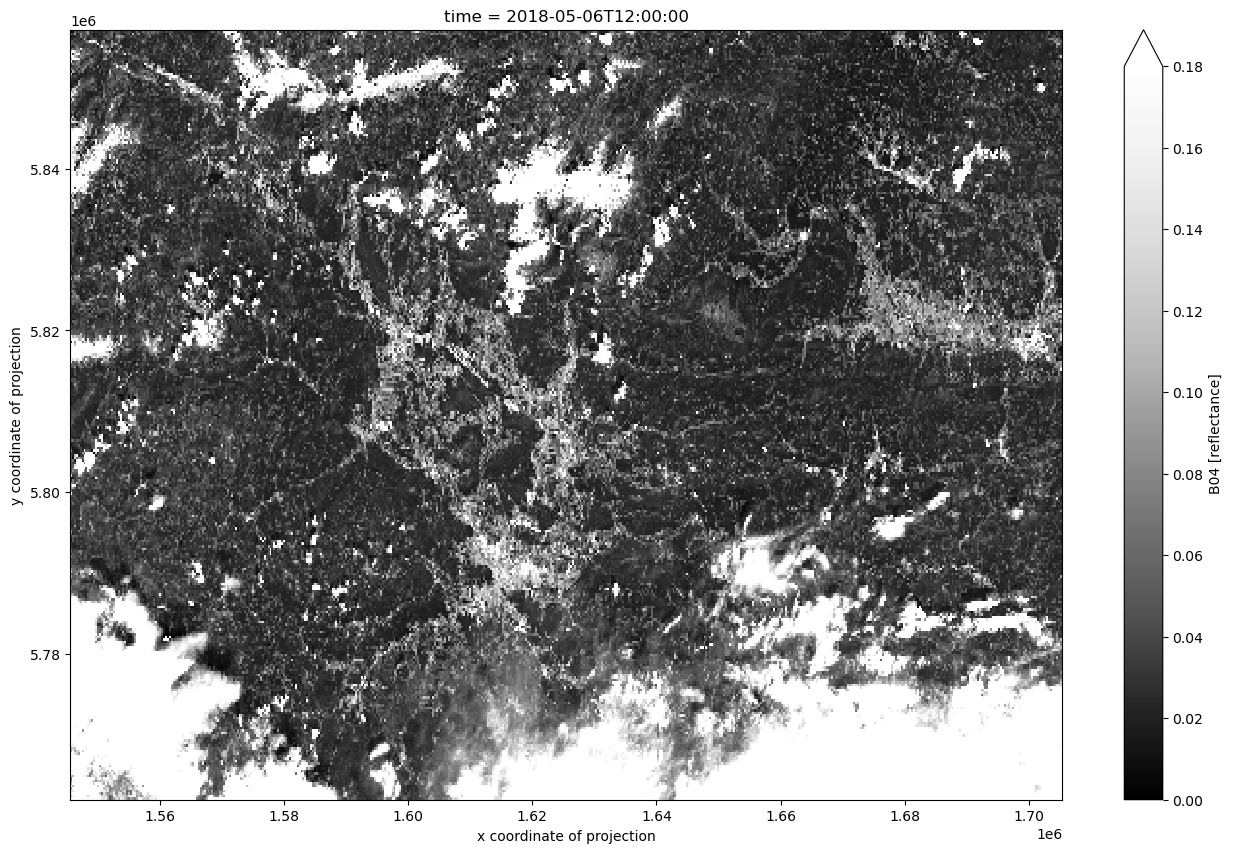

In [23]:
cube.B04.isel(time=5).plot.imshow(vmin=0, vmax=0.18, cmap='Greys_r', figsize=(16, 10))

---
### Example 1a4 - Writing to and Reopening from S3 Object Storage

We now want to write the cube from Example 3 to AWS S3 and then re-open it.

Writing to AWS usually requires credentials to be configured. There are three possible ways to do so:

1. Use the AWS CLI tool `aws configure` (see [AWS docs](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-files.html));
2. Set AWS environment variables `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY`;
3. Pass credentials as parameters `aws_access_key_id` and `aws_secret_access_key` in `s3_client_kwargs` to the xcube `open_cube` and `write_cube` functions.

For other object storage providers, the AWS settings usually work to. You just need to pass another `endpoint_url` in `s3_client_kwargs`, see below.

The xcube `open_cube` and `write_cube` functions have a path parameter that is either absolute `{endpoint_url}/{bucket_name}/{cube_name}` or relative `{bucket_name}/{cube_name}`. In the relative case, `endpoint_url` may be provided in `s3_client_kwargs`. If it is not given, it defaults to the well-known AWS S3 endpoint.

In [24]:
cube_path = 'https://s3.eu-central-1.amazonaws.com/xcube-examples/S2L2A-B04-Test-01.zarr'

Uncomment the code below to write the cube to your own s3 bucket using pre-configured credentials: 

In [25]:
#%%time
#write_cube(cube, output_path=cube_path)

In [26]:
# Note, we can also use s3_client_kwargs to pass the credentials directly or use another endpoint URL or region (all fields are optional):
# If endpoint_url is used then the given path should be relative and starting with the bucket name forllowed by the cube name.
# s3_client_kwargs = dict(aws_access_key_id='my_key', aws_secret_access_key='my_secret', endpoint_url='my_url', region_name='my_region')
# write_cube(cube, output_path=cube_path, s3_client_kwargs=s3_client_kwargs)

In [27]:
request_collector.stats

Number of requests:,44
Request duration min:,396.09 ms
Request duration max:,1685.62 ms
Request duration median:,585.90 ms
Request duration mean:,764.37 ms
Request duration std:,379.71 ms


The s3 bucket of the above specified `cube_path` is publicly readable, so you can have a look at the cube with the following line:

In [28]:
cube_from_bucket = xcube.core.dsio.open_cube(cube_path, s3_kwargs=dict(anon=True))

C:\Users\norma\AppData\Local\Temp\ipykernel_20716\2664283314.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) open_cube. (Functionality is redundant. Use xcube.core.store API instead.) -- Deprecated since version 0.12.1.
  cube_from_bucket = xcube.core.dsio.open_cube(cube_path, s3_kwargs=dict(anon=True))


In [29]:
cube_from_bucket

<xarray.Dataset>
Dimensions:    (time: 10, y: 305, x: 512, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2018-05-01T12:00:00 ... 2018-05-10T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(10, 2), meta=np.ndarray>
  * x          (x) float64 1.546e+06 1.546e+06 1.546e+06 ... 1.705e+06 1.705e+06
  * y          (y) float64 5.857e+06 5.857e+06 5.856e+06 ... 5.762e+06 5.762e+06
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    CLD        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
    SCL        (time, y, x) uint8 dask.array<chunksize=(1, 305, 512), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    date_created:              2020-12-09T13:25:28.581632
    history:                   [{'cube_config': {'band_names': ['B04', 'SCL',...
    processing_level:          L2A
    time_coverage_duration:    P10DT0H0M0S
    time_coverage_end:         2018-05-11T00:00:00+00:00
    time_coverage_resolution:  P1DT0H0M0S
    time_coverage_start:       2018-05-01T00:00:00+00:00
    title:                     S2L2A Data Cube Subset